https://levelup.gitconnected.com/building-a-million-parameter-llm-from-scratch-using-python-f612398f06c2

https://levelup.gitconnected.com/building-an-ai-text-to-video-model-from-scratch-using-python-35b4eb4002de

# config

In [1]:
%%capture

%pip install -U sentencepiece tiktoken blobfile huggingface_hub
%pip install -U -q lightning transformers
%pip install ipython-autotime

%load_ext autotime
%load_ext autoreload
%autoreload 2

time: 34.7 ms (started: 2025-01-23 16:36:23 +00:00)


# code loop style

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import tiktoken
from tiktoken.load import load_tiktoken_bpe
import torch
from torch import nn
from torch.nn import functional as F
from collections import OrderedDict

import urllib.request
import time
import json
import matplotlib.pyplot as plt
# from huggingface_hub import notebook_login
# notebook_login()

time: 8.18 s (started: 2025-01-23 15:49:32 +00:00)


## preprocess data

In [14]:
# The URL of the raw text file on GitHub
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"

# The file name for local storage
file_name = "tinyshakespeare.txt"

# Execute the download
urllib.request.urlretrieve(url, file_name)
# Read the content of the dataset
lines = open("tinyshakespeare.txt", 'r').read()

# Create a sorted list of unique characters in the dataset
vocab = sorted(list(set(lines)))

# Display the first 10 characters in the vocabulary list
print('Printing the first 10 characters of the vocab list:', vocab[:10])

# Output the total number of characters in our dataset (Vocabulary Size)
print('Total number of characters in our dataset (Vocabulary Size):', len(vocab))

Printing the first 10 characters of the vocab list: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3']
Total number of characters in our dataset (Vocabulary Size): 65
time: 194 ms (started: 2025-01-23 15:53:35 +00:00)


In [15]:
# Mapping integers to characters (itos)
itos = {i: ch for i, ch in enumerate(vocab)}

# Mapping characters to integers (stoi)
stoi = {ch: i for i, ch in enumerate(vocab)}

# Encode function: Converts a string to a list of integers using the mapping stoi
def encode(s):
    return [stoi[ch] for ch in s]

# Decode function: Converts a list of integers back to a string using the mapping itos
def decode(l):
    return ''.join([itos[i] for i in l])

# Convert the dataset into a torch tensor with specified data type (dtype)
dataset = torch.tensor(encode(lines), dtype=torch.int8)

# Display the shape of the resulting tensor
print(dataset.shape)

torch.Size([1115394])
time: 258 ms (started: 2025-01-23 15:53:35 +00:00)


In [16]:
MASTER_CONFIG = {}
# Function to get batches for training, validation, or testing
def get_batches(data, split, batch_size, context_window, config=MASTER_CONFIG):
    # Split the dataset into training, validation, and test sets
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]

    # Determine which split to use
    batch_data = train
    if split == 'val':
        batch_data = val
    if split == 'test':
        batch_data = test

    # Pick random starting points within the data
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))

    # Create input sequences (x) and corresponding target sequences (y)
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()

    return x, y

time: 82.9 ms (started: 2025-01-23 15:53:38 +00:00)


In [19]:
MASTER_CONFIG.update({
    'batch_size': 32,          # Number of batches to be processed at each random split
    'context_window': 16,    # Number of characters in each input (x) and target (y) sequence of each batch
    'd_model': 128,
    "vocab_size":len(vocab),
})
# Obtain batches for training using the specified batch size and context window
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Decode the sequences to obtain the corresponding text representations
decoded_samples = [(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

# Print the random sample
print(decoded_samples)

xs.shape, ys.shape

(torch.Size([32, 16]), torch.Size([32, 16]))

time: 71.5 ms (started: 2025-01-23 15:53:42 +00:00)


## model training func

In [24]:
@torch.no_grad()  # Don't compute gradients for this function
def evaluate_loss(model, config=MASTER_CONFIG):
    out = {}
    # Set the model to evaluation mode
    model.eval()

    # Iterate through training and validation splits
    for split in ["train", "val"]:
        losses = []
        # Generate 10 batches for evaluation
        for _ in range(10):
            # Get input sequences (xb) and target sequences (yb)
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])

            # Perform model inference and calculate the loss
            _, loss = model(xb, yb)

            # Append the loss to the list
            losses.append(loss.item())

        # Calculate the mean loss for the split and store it in the output dictionary
        out[split] = np.mean(losses)

    # Set the model back to training mode
    model.train()

    return out

time: 115 ms (started: 2025-01-23 15:54:52 +00:00)


In [25]:
from tqdm import tqdm

# Function to perform training
def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
    # Placeholder for storing losses
    losses = []

    # set model to training mode
    model.train()

    # Start tracking time
    start_time = time.time()

    # Iterate through epochs
    for epoch in tqdm(range(config['epochs'])):
        # Zero out gradients
        optimizer.zero_grad()

        # Obtain batches for training
        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])

        # Forward pass through the model to calculate logits and loss
        logits, loss = model(xs, targets=ys)

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # If a learning rate scheduler is provided, adjust the learning rate
        if scheduler:
            scheduler.step()

        # Log progress every specified interval
        if epoch % config['log_interval'] == 0:
            # Calculate batch time
            batch_time = time.time() - start_time

            # Evaluate loss on validation set
            x = evaluate_loss(model)

            # Store the validation loss
            losses += [x]

            # Print progress logs if specified
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")

            # Reset the timer
            start_time = time.time()

            # Print learning rate if a scheduler is provided
            if scheduler:
                print("lr: ", scheduler.get_lr())

    # Print the final validation loss
    print("Validation loss: ", losses[-1]['val'])

    # Plot the training and validation loss curves
    return pd.DataFrame(losses).plot()

time: 96.5 ms (started: 2025-01-23 15:54:53 +00:00)


In [26]:
# Generate function for text generation using the trained model
def generate(model, config=MASTER_CONFIG, max_new_tokens=30):
    idx = torch.zeros(5, 1).long()
    for _ in range(max_new_tokens):
        # Call the model
        logits = model(idx[:, -config['context_window']:])
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1)  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
    return [decode(x) for x in idx.tolist()]

time: 391 ms (started: 2025-01-23 15:54:55 +00:00)


##  LLaMA Architecture


In [ ]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()

        # Registering a learnable parameter 'scale' as a parameter of the module
        self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))
    def forward(self, x):
        """
        Assumes shape is (batch, seq_len, d_model)
        """
        # Calculating the Frobenius norm, RMS = 1/sqrt(N) * Frobenius norm
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5

        # Normalizing the input tensor 'x' with respect to RMS
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)

        # Scaling the normalized tensor using the learnable parameter 'scale'
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw


class RoPEMaskedAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Linear transformation for query
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        # Linear transformation for key
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        # Linear transformation for value
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)
        # Obtain rotary matrix for positional embeddings
        self.R = self.get_rotary_matrix(config['context_window'], config['d_model'])

    def get_rotary_matrix(self, context_window, embedding_dim):
        # Initialize a tensor for the rotary matrix with zeros
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)

        # Loop through each position in the context window
        for position in range(context_window):
            # Loop through each dimension in the embedding
            for i in range(embedding_dim // 2):
                # Calculate the rotation angle (theta) based on the position and embedding dimension
                theta = 10000. ** (-2. * (i - 1) / embedding_dim)
                # Calculate the rotated matrix elements using sine and cosine functions
                m_theta = position * theta
                R[position, 2 * i, 2 * i] = np.cos(m_theta)
                R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
        return R


    def forward(self, x, return_attn_weights=False):
        # x: input tensor of shape (batch_size, sequence length, dimension)

        b, m, d = x.shape  # batch size, sequence length, dimension

        # Linear transformations for Q, K, and V
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        # Rotate Q and K using the RoPE matrix
        q_rotated = (torch.bmm(q.transpose(0, 1), self.R[:m])).transpose(0, 1)
        k_rotated = (torch.bmm(k.transpose(0, 1), self.R[:m])).transpose(0, 1)

        # Perform scaled dot-product attention
        activations = F.scaled_dot_product_attention(
            q_rotated, k_rotated, v, dropout_p=0.1, is_causal=True
        )

        if return_attn_weights:
            # Create a causal attention mask
            attn_mask = torch.tril(torch.ones((m, m)), diagonal=0)
            # Calculate attention weights and add causal mask
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1, 2)) / np.sqrt(d) + attn_mask
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights

        return activations

class RoPEMaskedMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Create a list of RoPEMaskedAttentionHead instances as attention heads
        self.heads = nn.ModuleList([
            RoPEMaskedAttentionHead(config) for _ in range(config['n_heads'])
        ])
        self.linear = nn.Linear(config['n_heads'] * config['d_model'], config['d_model'])  # Linear layer after concatenating heads
        self.dropout = nn.Dropout(.1)  # Dropout layer

    def forward(self, x):
        # x: input tensor of shape (batch, sequence length, dimension)

        # Process each attention head and concatenate the results
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)

        # Apply linear transformation to the concatenated output
        x = self.linear(x)

        # Apply dropout
        x = self.dropout(x)
        return x

class SwiGLU(nn.Module):
    """ Paper Link -> https://arxiv.org/pdf/2002.05202v1.pdf """
    def __init__(self, size):
        super().__init__()
        self.linear_gate = nn.Linear(size, size)  # Linear transformation for the gating mechanism
        self.linear = nn.Linear(size, size)  # Linear transformation for the main branch
        self.beta = torch.randn(1, requires_grad=True)  # Random initialization of the beta parameter

        # Using nn.Parameter for beta to ensure it's recognized as a learnable parameter
        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)

    def forward(self, x):
        # Swish-Gated Linear Unit computation
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)  # Element-wise multiplication of the gate and main branch
        return out

time: 63.7 ms (started: 2025-01-18 10:48:10 +00:00)


In [27]:
# add RMSNorm and residual connection
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # RMSNorm layer
        self.rms = RMSNorm((config['context_window'], config['d_model']))

        # RoPE Masked Multihead Attention layer
        self.attention = RoPEMaskedMultiheadAttention(config)

        # Feedforward layer with SwiGLU activation
        self.feedforward = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

    def forward(self, x):
        # one block of attention
        x = self.rms(x) # RMS pre-normalization
        x = x + self.attention(x)  # residual connection

        x = self.rms(x) # RMS pre-normalization
        x = x + self.feedforward(x)  # residual connection
        return x

class Llama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Embedding layer for token representations
        self.embeddings = nn.Embedding(config['vocab_size'], config['d_model'])
        # Sequential block of LlamaBlocks based on the specified number of layers
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])])
        )
        # Feedforward network (FFN) for final output
        self.ffn = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        # Print total number of parameters in the model
        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        # Input token indices are passed through the embedding layer
        x = self.embeddings(idx)
        # Process the input through the LlamaBlocks
        x = self.llama_blocks(x)
        # Pass the processed input through the final FFN for output logits
        logits = self.ffn(x)

        # If targets are not provided, return only the logits
        if targets is None:
            return logits
        # If targets are provided, compute and return the cross-entropy loss
        else:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

time: 129 ms (started: 2025-01-23 15:55:42 +00:00)


In [28]:
MASTER_CONFIG = {
    'batch_size': 64,
    'context_window': 16,
    'd_model': 128,
    'vocab_size': 65,
    'epochs': 5000,
    'log_interval': 10,
    'n_heads': 8,
    'n_layers': 4
}

# Create an instance of RopeModel (RMSNorm, RoPE, Multi-Head, SwiGLU, N_layers)
llama = Llama(MASTER_CONFIG)

# Obtain batches for training
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Calculate logits and loss using the model
logits, loss = llama(xs, ys)

model params: 2370246
time: 3.65 s (started: 2025-01-23 15:55:59 +00:00)


In [50]:
xs.shape, ys.shape

(torch.Size([64, 16]), torch.Size([64, 16]))

time: 178 ms (started: 2025-01-23 16:15:04 +00:00)


In [33]:
logits.shape, loss

(torch.Size([64, 16, 65]), tensor(4.1688, grad_fn=<NllLossBackward0>))

time: 97.3 ms (started: 2025-01-23 15:56:52 +00:00)


In [ ]:
# Define the Adam optimizer for model parameters
optimizer = torch.optim.Adam(llama.parameters())

train(llama, optimizer, config=MASTER_CONFIG)

time: 126 ms (started: 2025-01-19 14:17:42 +00:00)


In [ ]:
generated_text = generate(llama, MASTER_CONFIG, 500)[0]
print(generated_text)

In [ ]:
# Get batches from the test set
xs, ys = get_batches(dataset, 'test', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Pass the test data through the LLaMA model
logits, loss = llama(xs, ys)

# Print the loss on the test set
print(loss)

# Torch lightning module

## Data Loader

In [2]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
from tqdm import tqdm
import regex as re
from sklearn.model_selection import train_test_split
from collections import OrderedDict
import random
import urllib.request
import time
import json

import lightning.pytorch as L  # For PyTorch Lightning functionality
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping  # Model callbacks
from lightning.pytorch.callbacks import ModelSummary  # For summarizing model architecture
from lightning.pytorch import Trainer, seed_everything
import torchmetrics  # For PyTorch metrics computation
import torch  # For PyTorch deep learning framework
from torch import nn  # For building neural network modules
from torch.nn import functional as F
import torchvision  # For computer vision utilities and datasets
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import AutoTokenizer, AutoModel


import tiktoken
from tiktoken.load import load_tiktoken_bpe

# import nltk
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('punkt_tab')

def set_seed(seed: int = 0) -> None:
    """Set random seed for reproducibility across numpy, random, torch, and CUDA."""
    np.random.seed(seed)  # Seed for numpy operations
    random.seed(seed)  # Seed for random module
    torch.manual_seed(seed)  # Seed for PyTorch on CPU
    torch.cuda.manual_seed(seed)  # Seed for PyTorch on CUDA GPU

    # Ensure reproducibility on CuDNN backend
    torch.backends.cudnn.deterministic = True  # Disable nondeterministic algorithms
    torch.backends.cudnn.benchmark = False  # Disable performance optimizations for determinism

    # Set a fixed value for the hash seed for reproducibility
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")  # Confirm seed setting

# Set default seed for reproducibility
set_seed()

Random seed set as 0
time: 27.4 s (started: 2025-01-23 16:36:23 +00:00)


In [3]:
# The URL of the raw text file on GitHub
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"

# The file name for local storage
file_name = "tinyshakespeare.txt"

# Execute the download
urllib.request.urlretrieve(url, file_name)

# Read the content of the dataset
data_text = open("tinyshakespeare.txt", 'r').read()

time: 362 ms (started: 2025-01-23 16:36:50 +00:00)


In [4]:
class CustomDataset(Dataset):
    def __init__(self, text, label, tokenizer, max_length):
        self.text = text
        self.label = label
        self.tokenizer = tokenizer # used pre-trained tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        # text = str(self.text[idx])
        # label = str(self.label[idx])
        # try:
        #     encoding = self.tokenizer.encode_plus(
        #         text,
        #         add_special_tokens=True,
        #         max_length=self.max_length,
        #         padding="max_length",
        #         truncation=True,
        #         return_tensors="pt",
        #     )
        #     label_encoding = self.tokenizer.encode_plus(
        #         label,
        #         add_special_tokens=True,
        #         max_length=self.max_length,
        #         padding="max_length",
        #         truncation=True,
        #         return_tensors="pt",
        #     )
        # except Exception as e:
        #     raise ValueError(f"Error in tokenization: {e}")


        # input_ids = encoding["input_ids"].squeeze()
        # attention_mask = encoding["attention_mask"].squeeze()
        # labels = label_encoding["input_ids"].squeeze()

        # assert input_ids.shape[0] == attention_mask.shape[0] == labels.shape[0] == self.max_length
        # assert input_ids.max() < self.tokenizer.vocab_size, "Input contains indices out of range."

        # return {
        #     "input_ids": input_ids,
        #     "attention_mask": attention_mask,
        #     "label": labels
        # }
        return {
            "input_ids": self.text[idx],
            "label": self.label[idx]
        }

class LLamaDataModule(L.LightningDataModule):
    def __init__(self, config, data_text):
        super().__init__()
        self.config = config
        # self.data_text = torch.tensor([ord(char) for char in data_text], dtype = torch.long)
        self.data_text = data_text
        # Actual tokenizer of Llama architecture is SentencePiece Byte-pair encoding
        # https://github.com/google/sentencepiece
        self.tokenizer = AutoTokenizer.from_pretrained(self.config["tokenizer_model"])
        self.vocab_size = self.config["vocab_size"]
        self.context_window = self.config["context_window"]
        self.batch_size = self.config["batch_size"]
        self.num_workers = self.config["num_workers"]

    # Encode function: Converts a string to a list of integers using the mapping stoi
    def encode(self, input_text):
        return [self.stoi[ch] for ch in input_text]

    # Decode function: Converts a list of integers back to a string using the mapping itos
    def decode(self, input_ids):
        return ''.join([itos[i] for i in input_ids])

    def setup(self, stage=None):
        # Create a sorted list of unique characters in the dataset
        vocab = sorted(list(set(self.data_text)))
        # Mapping integers to characters (itos)
        itos = {i: ch for i, ch in enumerate(vocab)}
        # Mapping characters to integers (stoi)
        stoi = {ch: i for i, ch in enumerate(vocab)}
        self.stoi = stoi
        self.itos = itos
        # Convert the dataset into a torch tensor with specified data type (dtype)
        self.dataset = torch.tensor(self.encode(self.data_text), dtype = torch.int8)

        # pick random starting point within data
        # ix  = torch.randint(0, len(self.dataset) - self.context_window -1, (self.batch_size, ))
        indices = torch.arange(len(self.dataset) - self.context_window)
        self.text = torch.stack(
            [self.dataset[i:i + self.context_window] for i in indices]
        ).long()
        self.label = torch.stack(
            [self.dataset[i + 1:i + self.context_window + 1] for i in indices]
        ).long()

        # self.text = self.dataset.unfold(0, self.context_window, 1)[ix]
        # self.label = self.dataset.unfold(0, self.context_window, 1)[ix + 1]

        # split dataset into train, val, test
        text_train, text_val, label_train, label_val = train_test_split(
            self.text, self.label, test_size=0.2, random_state=0, shuffle = True
        )
        text_val, text_test, label_val, label_test = train_test_split(
            text_val, label_val, test_size=0.5, random_state=0, shuffle = True
        )

        self.train_dataset  = CustomDataset(text_train, label_train, self.tokenizer, self.vocab_size)
        self.val_dataset = CustomDataset(text_val, label_val, self.tokenizer, self.vocab_size)
        self.test_dataset = CustomDataset(text_test, label_test, self.tokenizer, self.vocab_size)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers = self.num_workers
        )

time: 100 ms (started: 2025-01-23 16:36:51 +00:00)


## LLama module

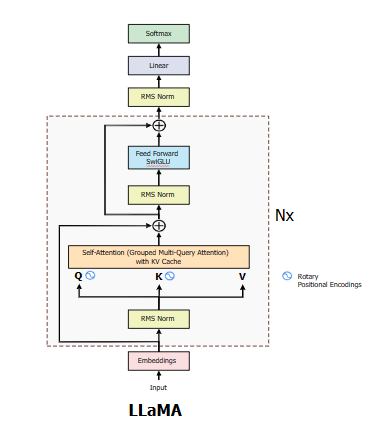

### LLama components

In [16]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()

        # Registering a learnable parameter 'scale' as a parameter of the module
        self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))
    def forward(self, x):
        """
        Assumes shape is (batch, seq_len, d_model)
        """
        # Calculating the Frobenius norm, RMS = 1/sqrt(N) * Frobenius norm
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5

        # Normalizing the input tensor 'x' with respect to RMS
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)

        # Scaling the normalized tensor using the learnable parameter 'scale'
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw


class RoPEMaskedAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Linear transformation for query
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        # Linear transformation for key
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        # Linear transformation for value
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)
        # Obtain rotary matrix for positional embeddings
        self.R = self.get_rotary_matrix(config['context_window'], config['d_model'])

    def get_rotary_matrix(self, context_window, embedding_dim):
        # Initialize a tensor for the rotary matrix with zeros
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)

        # Loop through each position in the context window
        for position in range(context_window):
            # Loop through each dimension in the embedding
            for i in range(embedding_dim // 2):
                # Calculate the rotation angle (theta) based on the position and embedding dimension
                theta = 10000. ** (-2. * (i - 1) / embedding_dim)
                # Calculate the rotated matrix elements using sine and cosine functions
                m_theta = position * theta
                R[position, 2 * i, 2 * i] = np.cos(m_theta)
                R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
        return R


    def forward(self, x, return_attn_weights=False):
        # x: input tensor of shape (batch_size, sequence length, dimension)

        b, m, d = x.shape  # batch size, sequence length, dimension

        # Linear transformations for Q, K, and V
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        device = q.device  # Assuming `q` is already on the correct device
        self.R = self.R.to(device)  # Move `self.R` to the same device as `q`

        # Rotate Q and K using the RoPE matrix
        q_rotated = (torch.bmm(q.transpose(0, 1), self.R[:m])).transpose(0, 1)
        k_rotated = (torch.bmm(k.transpose(0, 1), self.R[:m])).transpose(0, 1)

        # Perform scaled dot-product attention
        activations = F.scaled_dot_product_attention(
            q_rotated, k_rotated, v, dropout_p=0.1, is_causal=True
        )

        if return_attn_weights:
            # Create a causal attention mask
            attn_mask = torch.tril(torch.ones((m, m)), diagonal=0)
            # Calculate attention weights and add causal mask
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1, 2)) / np.sqrt(d) + attn_mask
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights

        return activations

class RoPEMaskedMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Create a list of RoPEMaskedAttentionHead instances as attention heads
        self.heads = nn.ModuleList([
            RoPEMaskedAttentionHead(config) for _ in range(config['n_heads'])
        ])
        self.linear = nn.Linear(config['n_heads'] * config['d_model'], config['d_model'])  # Linear layer after concatenating heads
        self.dropout = nn.Dropout(.1)  # Dropout layer

    def forward(self, x):
        # x: input tensor of shape (batch, sequence length, dimension)

        # Process each attention head and concatenate the results
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)

        # Apply linear transformation to the concatenated output
        x = self.linear(x)

        # Apply dropout
        x = self.dropout(x)
        return x

class SwiGLU(nn.Module):
    """ Paper Link -> https://arxiv.org/pdf/2002.05202v1.pdf """
    def __init__(self, size):
        super().__init__()
        self.linear_gate = nn.Linear(size, size)  # Linear transformation for the gating mechanism
        self.linear = nn.Linear(size, size)  # Linear transformation for the main branch
        self.beta = torch.randn(1, requires_grad=True)  # Random initialization of the beta parameter

        # Using nn.Parameter for beta to ensure it's recognized as a learnable parameter
        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)

    def forward(self, x):
        # Swish-Gated Linear Unit computation
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)  # Element-wise multiplication of the gate and main branch
        return out

time: 84.8 ms (started: 2025-01-23 16:57:31 +00:00)


### LLama trainer

In [22]:
# add RMSNorm and residual connection
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # RMSNorm layer
        self.rms = RMSNorm((config['context_window'], config['d_model']))

        # RoPE Masked Multihead Attention layer
        self.attention = RoPEMaskedMultiheadAttention(config)

        # Feedforward layer with SwiGLU activation
        self.feedforward = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

    def forward(self, x):
        # one block of attention
        x = self.rms(x) # RMS pre-normalization
        x = x + self.attention(x)  # residual connection

        x = self.rms(x) # RMS pre-normalization
        x = x + self.feedforward(x)  # residual connection
        return x

class LLamaGeneration(L.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.learning_rate = self.config["learning_rate"]
        self.tokenizer = AutoTokenizer.from_pretrained(self.config["tokenizer_model"])
        # use pre-trained model
        # self.llama_model = AutoModel.from_pretrained(self.config["llama_path_pre-trained_model"])

        # or
        self.embedding = nn.Embedding(
            self.config["vocab_size"],
            self.config["d_model"],
            # padding_idx=self.tokenizer.pad_token_id
        )

        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_block{i}", LlamaBlock(self.config)) for i in range(self.config["n_layer"])])
        )

        self.fc_layer = nn.Sequential(
            # RMSNorm((self.config["d_model"], self.config["d_model"])),
            nn.Linear(self.config["d_model"], self.config["d_model"]),
            SwiGLU(self.config["d_model"]),
            nn.Linear(self.config["d_model"], self.config["vocab_size"])
        )

    def forward(self, input_idx, attention_mask=None):
        # Extract features from pre-trained model
        # outputs = self.bert(input_ids, attention_mask=attention_mask)
        x = self.embedding(input_idx)
        x = self.llama_blocks(x)
        logits = self.fc_layer(x)
        return logits

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        # attention_mask = batch['attention_mask']
        # labels = torch.reshape(batch['label'], (-1, 1))
        labels = batch["label"]

        # Forward pass and compute loss
        predicted_value = self(input_ids)
        predicted_value = predicted_value.view(-1, self.config['vocab_size'])
        labels = labels.view(-1)

        loss = F.cross_entropy(predicted_value, labels)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)  # Log loss
        return loss

    def validation_step(self, batch, batch_idx):
        """
        Performs a single training step.
        """
        input_ids = batch['input_ids']
        # attention_mask = batch['attention_mask']
        # labels = torch.reshape(batch['label'], (-1, 1))
        labels = batch["label"]

        # Forward pass and compute loss
        predicted_value = self(input_ids)
        predicted_value = predicted_value.view(-1, self.config['vocab_size'])
        labels = labels.view(-1)

        val_loss = F.cross_entropy(predicted_value, labels)  # Mean squared error loss
        self.log("val_loss", val_loss, on_step=False, on_epoch=True, prog_bar=True)  # Log loss
        return val_loss

    def test_step(self, batch, batch_idx):
        """
        Performs a single training step.
        """
        input_ids = batch['input_ids']
        # attention_mask = batch['attention_mask']
        # labels = torch.reshape(batch['label'], (-1, 1))
        labels = batch["label"]

        # Forward pass and compute loss
        predicted_value = self(input_ids)
        predicted_value = predicted_value.view(-1, self.config['vocab_size'])
        labels = labels.view(-1)

        val_loss = F.cross_entropy(predicted_value, labels)  # Mean squared error loss
        self.log("val_loss", val_loss, on_step=False, on_epoch=True, prog_bar=True)  # Log loss
        return val_loss

    def configure_optimizers(self):
        """
        Configures the optimizer for training.
        """
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)  # AdamW optimizer
        return optimizer

time: 101 ms (started: 2025-01-23 17:01:39 +00:00)


## Train model

In [30]:
MASTER_CONFIG = {
    'batch_size': 2560,
    'context_window': 16,
    'd_model': 128,
    'vocab_size': 65,
    "n_heads": 8,
    "n_layer": 4,
    "num_workers": 1,
    "tokenizer_model":"google-bert/bert-base-cased",
    # "tokenizer_model":"FacebookAI/roberta-base",
    "learning_rate":1e-4,
}
# MASTER_CONFIG.update({
#     "vocab_size": AutoTokenizer.from_pretrained(MASTER_CONFIG["tokenizer_model"]).vocab_size,
# })
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model.to(device)

data_module = LLamaDataModule(
    data_text=data_text,
    config = MASTER_CONFIG
)
data_module.setup()

model = LLamaGeneration(config = MASTER_CONFIG)

time: 47.3 s (started: 2025-01-23 17:07:19 +00:00)


In [31]:
sample_training = next(iter(data_module.train_dataloader()))["input_ids"]
sample_output = model.forward(input_idx = sample_training)
 (
    sample_training.shape,
    next(iter(data_module.train_dataloader()))["label"].shape,
    sample_output.shape,
    sample_output.view(-1, MASTER_CONFIG['vocab_size']).shape
)

(torch.Size([2560, 16]),
 torch.Size([2560, 16]),
 torch.Size([2560, 16, 65]),
 torch.Size([40960, 65]))

time: 19.9 s (started: 2025-01-23 17:08:06 +00:00)


In [32]:
model_checkpoint = ModelCheckpoint(
    dirpath='checkpoint/',
    monitor="val_loss",
    verbose=True,
    mode="min",
    save_top_k=1
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    min_delta=1e-4,
    patience=5
)

callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=2)]

trainer = L.Trainer(
    max_epochs=50,
    detect_anomaly=True,
    callbacks=callbacks
)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
IN

time: 2.17 s (started: 2025-01-23 17:08:26 +00:00)


In [33]:
trainer.fit(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name                      | Type       | Params | Mode 
-----------------------------------------------------------------
0 | embedding                 | Embedding  | 8.3 K  | train
1 | llama_blocks              | Sequential | 2.3 M  | train
2 | llama_blocks.llama_block0 | LlamaBlock | 576 K  | train
3 | llama_blocks.llama_block1 | LlamaBlock | 576 K  | train
4 | llama_blocks.llama_block2 | LlamaBlock | 576 K  | train
5 | llama_blocks.llama_block3 | LlamaBlock | 576 K  | train
6 | fc_layer                  | Sequential | 57.9 K | train
7 | fc_layer.0                | Linear     | 16.5 K | train
8 | fc_layer.1                | SwiGLU     | 33.0 K | train
9 | fc_layer.2                | Linear     | 8.4 K  | train
-----------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     To

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 349: 'val_loss' reached 1.95565 (best 1.95565), saving model to '/content/checkpoint/epoch=0-step=349.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 349: 'val_loss' reached 1.95565 (best 1.95565), saving model to '/content/checkpoint/epoch=0-step=349.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 698: 'val_loss' reached 1.69394 (best 1.69394), saving model to '/content/checkpoint/epoch=1-step=698.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 698: 'val_loss' reached 1.69394 (best 1.69394), saving model to '/content/checkpoint/epoch=1-step=698.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 1047: 'val_loss' reached 1.55029 (best 1.55029), saving model to '/content/checkpoint/epoch=2-step=1047.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 1047: 'val_loss' reached 1.55029 (best 1.55029), saving model to '/content/checkpoint/epoch=2-step=1047.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 1396: 'val_loss' reached 1.47479 (best 1.47479), saving model to '/content/checkpoint/epoch=3-step=1396.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 1396: 'val_loss' reached 1.47479 (best 1.47479), saving model to '/content/checkpoint/epoch=3-step=1396.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 1745: 'val_loss' reached 1.42449 (best 1.42449), saving model to '/content/checkpoint/epoch=4-step=1745.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 1745: 'val_loss' reached 1.42449 (best 1.42449), saving model to '/content/checkpoint/epoch=4-step=1745.ckpt' as top 1
INFO: 
Detected KeyboardInterrupt, attempting graceful shutdown ...
INFO:lightning.pytorch.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

time: 50min 5s (started: 2025-01-23 17:08:28 +00:00)


In [ ]:
trainer.test(model, data_module.test_dataloader())